# Load 
Loading data and removing whitespace from header

In [1]:
import os
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

spark = SparkSession.builder.master("local").getOrCreate()
samples = spark.read.csv(
    os.path.expanduser("~/data/DataSample.csv"),
    header=True,
    sep=",",
    inferSchema="True",
)
points = spark.read.csv(
    os.path.expanduser("~/data/POIList.csv"), header=True, sep=",", inferSchema="True"
)
# removing excess whitespace in headers
for each in samples.schema.names:
    samples = samples.withColumnRenamed(each, each.strip())
for each in points.schema.names:
    points = points.withColumnRenamed(each, each.strip())
samples = samples.withColumn("TimeSt", F.to_timestamp("TimeSt"))

In [2]:
samples.show(5, truncate=False)
points.show(truncate=False)
print(f"There are {samples.count()} rows in DataSample.csv")
print(f"There are {points.count()} rows in the POIList.csv")
samples.dtypes, points.dtypes

+-------+-----------------------+-------+--------+---------+--------+---------+
|_ID    |TimeSt                 |Country|Province|City     |Latitude|Longitude|
+-------+-----------------------+-------+--------+---------+--------+---------+
|4516516|2017-06-21 00:00:00.143|CA     |ON      |Waterloo |43.49347|-80.49123|
|4516547|2017-06-21 18:00:00.193|CA     |ON      |London   |42.9399 |-81.2709 |
|4516550|2017-06-21 15:00:00.287|CA     |ON      |Guelph   |43.5776 |-80.2201 |
|4516600|2017-06-21 15:00:00.307|CA     |ON      |Stratford|43.3716 |-80.9773 |
|4516613|2017-06-21 15:00:00.497|CA     |ON      |Stratford|43.3716 |-80.9773 |
+-------+-----------------------+-------+--------+---------+--------+---------+
only showing top 5 rows

+-----+---------+-----------+
|POIID|Latitude |Longitude  |
+-----+---------+-----------+
|POI1 |53.546167|-113.485734|
|POI2 |53.546167|-113.485734|
|POI3 |45.521629|-73.566024 |
|POI4 |45.22483 |-63.232729 |
+-----+---------+-----------+

There are 2202

([('_ID', 'int'),
  ('TimeSt', 'timestamp'),
  ('Country', 'string'),
  ('Province', 'string'),
  ('City', 'string'),
  ('Latitude', 'double'),
  ('Longitude', 'double')],
 [('POIID', 'string'), ('Latitude', 'double'), ('Longitude', 'double')])

# 1. Cleanup

Find the sample dataset of request logs in `data/DataSample.csv`. We consider records with identical `geoinfo` and `timest` as suspicious. Please clean up the sample dataset by filtering out those questionable request records.

# Q1 Solution

In [3]:
# removing all of the duplicated request
samples = samples.join(
    samples.groupBy("Latitude", "Longitude", "TimeSt")
    .count()
    .where("count=1")
    .drop("count"),
    on=["Latitude", "Longitude", "TimeSt"],
)
print(f"There are {samples.count()} rows in the cleaned DataSample.csv")

There are 17973 rows in the cleaned DataSample.csv


In [39]:
# there were 40 instances of duplicated TimeSt that I missed
samples.groupBy('TimeSt').count().where('count > 1').groupBy('count').count().show()

+-----+-----+
|count|count|
+-----+-----+
|    2|   20|
+-----+-----+



# 2. Label

Assign each *request* (from `data/DataSample.csv`) to the closest (i.e., minimum distance) *POI* (from `data/POIList.csv`).

Note: a *POI* is a geographical Point of Interest.

## Notes

- Need to convert coordinates to radians and use angular distance because the earth isnt flat...

### haversine
$$d=\theta r$$ 
Where **d** is the arc length of the corresponding angle $\theta$ of sphere with radius **r**
Can compute **d** by computing $hav(\theta)$, which can be computed as the difference of the longitude and latitude of two points defining the arc.

With $$\begin{aligned} h&=hav(\theta) \\
&=\sin^2{\frac{\theta}{2}}\\
&=\frac{1-\cos{\theta}}{2}\\
&=hav(\phi_2-\phi_1)+(1-hav(\phi_1-\phi_2)-hav(\phi_1+\phi_2))\cdot hav(\lambda_2-\lambda_1) \end{aligned}$$

Where $\phi$ is the latitude and $\lambda$ is the longitude

Solving for **d**:
$$\begin{aligned} d&=2r\arcsin{\sqrt{h}} \\
&= 2r\arcsin{\sqrt{\sin^2{\frac{\phi_2-\phi_1}{2}}+\cos{\phi_1}\cdot\cos{\phi_2}\cdot\sin^2{\frac{\lambda_2-\lambda_1}{2}}}} \end{aligned}$$

- Answers have errors that are no better than 0.5% due to variation of earth's radius (needed citation)
- $h\in [0,1]$ for $d\in \mathbb{R}$
- R=6371 KM

```python
from sklearn.metrics import DistanceMetric
import numpy as np


dist = DistanceMetric.get_metric('haversine')
def closest_point(point, points):
    """ Find closest point from a list of points. """
    return points[dist.pairwise([point], points).argmin()]

ds['point'] = [(x, y) for x,y in zip(np.radians(ds['Latitude']), np.radians(ds['Longitude']))]
poi['point'] = [(x, y) for x,y in zip(np.radians(poi['Latitude']), np.radians(poi['Longitude']))]
ds['closest'] = [closest_point(x, list(poi['point'])) for x in ds['point']]
ds = ds.merge(poi[['POIID', 'point']].round(4), how='left', validate = 'm:1',
         left_on='closest', right_on='point').drop(['closest', 'point_x', 'point_y'], axis=1)
```

Pandas implementation relatively easy, need to figure out how to implement in spark without looping over the columns

# Q2 Solution

In [46]:
# will be using SQL
points.createOrReplaceTempView("points")
samples.createOrReplaceTempView("samples")

In [47]:
# query to calculate distance
query = """
SELECT _ID,
        p.POIID,
        ROUND(2 * 6371 * ASIN(SQRT(POW(SIN((RADIANS(p.Latitude)-RADIANS(s.Latitude)) * 0.5), 2)
            +COS(RADIANS(s.Latitude))*COS(RADIANS(p.Latitude))
            *POW(SIN((RADIANS(p.Longitude)-RADIANS(s.Longitude)) * 0.5),2))), 5) as dist_km
FROM samples s CROSS JOIN 
(
SELECT  POIID,
        Latitude,
        Longitude
FROM points) AS p ON 1=1
ORDER BY s._ID"""

In [7]:
# https://stackoverflow.com/questions/61760132/fastest-way-to-calculate-minimum-haversine-distance-between-lat-long-an-array
# nearest neighbor type optimization problem, KDtree?

# https://johnlekberg.com/blog/2020-04-17-kd-tree.html
# seems like if we construct a KDtree we'll have to collect n exit spark df
# maybe storing points as a maptype in samples? not sure how I would implement this

In [48]:
# group request from same location and order them by distance (descending)
# assign row number and show only the first (closest) POIID
from pyspark.sql.window import Window

w = Window.partitionBy(["_ID"]).orderBy("dist_km")

# dataframe with each request assigned to the closest POI
assigned = (
    spark.sql(query)
    .withColumn("rn", F.row_number().over(w))
    .where(F.col("rn") == 1)
    .drop("rn")
    .orderBy("_ID", ascending=False)
)

In [49]:
assigned.show()

+-------+-----+---------+
|    _ID|POIID|  dist_km|
+-------+-----+---------+
|5615006| POI3|544.65131|
|5614912| POI3| 536.8741|
|5614909| POI3|461.99513|
|5614801| POI3| 522.0193|
|5614689| POI3|674.21123|
|5614602| POI3|674.21123|
|5614566| POI1|818.27649|
|5614548| POI1|143.94017|
|5614515| POI1|143.23494|
|5614446| POI1|281.13286|
|5614377| POI3| 502.6455|
|5614303| POI3|503.72753|
|5614181| POI1|143.94017|
|5614136| POI3| 494.0298|
|5614047| POI3|528.93372|
|5613968| POI3|489.22103|
|5613874| POI3|163.01963|
|5613826| POI3|533.36461|
|5613790| POI3|549.75028|
|5613763| POI3|550.20888|
+-------+-----+---------+
only showing top 20 rows



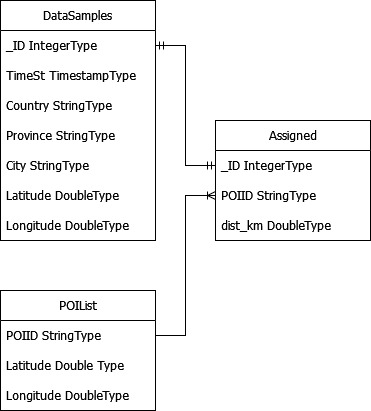

In [1]:
from IPython.display import Image
Image(filename='assets\EQ_Works_Schema.jpg') 

In [10]:
# write assigned requests to new file, optional
# assigned.write.csv(
#     os.path.expanduser("~/data/AssignedDataSample.csv"),
#     header=True,
#     sep=",",
# )
# spark.catalog.dropTempView("samples")
# spark.catalog.dropTempView("points")

In [50]:
# Not going to consider the milisec difference in timestamp as suspicious
# since 12 other requests were made during that time
spark.sql(
    """ 
SELECT * 
FROM samples
WHERE _ID=4516600 OR _ID=4516613
"""
).show(truncate=False, vertical=True)

-RECORD 0----------------------------
 TimeSt    | 2017-06-21 15:00:00.307 
 Latitude  | 43.3716                 
 Longitude | -80.9773                
 _ID       | 4516600                 
 Country   | CA                      
 Province  | ON                      
 City      | Stratford               
-RECORD 1----------------------------
 TimeSt    | 2017-06-21 15:00:00.497 
 Latitude  | 43.3716                 
 Longitude | -80.9773                
 _ID       | 4516613                 
 Country   | CA                      
 Province  | ON                      
 City      | Stratford               



# 3. Analysis
1. For each *POI*, calculate the average and standard deviation of the distance between the *POI* to each of its assigned *requests*.
2. At each *POI*, draw a circle (with the center at the POI) that includes all of its assigned *requests*. Calculate the radius and density (requests/area) for each *POI*.

In [51]:
analysis = assigned.groupBy('POIID').agg(F.avg('dist_km').alias('avg_dist_km'), F.stddev('dist_km').alias('avg_stdev'), F.max('dist_km').alias('max_dist_km'), F.count('*').alias('num_requests'))

analysis.createOrReplaceTempView("analysis")
analysis.show()

+-----+------------------+------------------+-----------+------------+
|POIID|       avg_dist_km|         avg_stdev|max_dist_km|num_requests|
+-----+------------------+------------------+-----------+------------+
| POI4| 517.4837900000005|1511.9820385829657| 9349.57277|         419|
| POI1| 300.6753308918157| 388.3868984762896|11531.82083|        8735|
| POI3|451.81352890990354|223.66929456118675| 1474.58096|        8779|
+-----+------------------+------------------+-----------+------------+



In [53]:
analysis_query = """
SELECT 
    POIID,
    ROUND(avg_dist_km, 5) AS avg_dist_km,
    ROUND(avg_stdev, 5) AS avg_stdev, 
    num_requests / (PI()*POW(max_dist_km, 2)) AS density
FROM
    analysis
ORDER BY
    POIID
"""
spark.sql(analysis_query).show(truncate=False)

+-----+-----------+----------+---------------------+
|POIID|avg_dist_km|avg_stdev |density              |
+-----+-----------+----------+---------------------+
|POI1 |300.67533  |388.3869  |2.0908229782099422E-5|
|POI3 |451.81353  |223.66929 |0.0012851621678767263|
|POI4 |517.48379  |1511.98204|1.525740301163449E-6 |
+-----+-----------+----------+---------------------+



# 4. Modelling

1. To visualize the popularity of each *POI*, map them to a scale that ranges from -10 to 10. Please provide a mathematical model to implement this, considering extreme cases and outliers. Aim to be more sensitive around the average and give as much visual differentiability as possible.
2. **Bonus**: Try to develop reasonable hypotheses regarding *POIs*, state all assumptions, testing steps, and conclusions. Include this as a text file (with the name `bonus`) in your final submission.